# 模型选择

## 训练误差和泛化误差
- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差
- 例子：根据模考成绩来预测未来考试分数
  - 在过去的考试中表现很好（训练误差）不代表未来考试一定会好（泛化性差）
  - 学生A通过背书在模考中拿到很好的成绩
  - 学生B知道答案后面的原因  

## 验证数据集和测试数据集

- 验证数据集：一个用来评估模型好坏的数据集
  - 例如拿出50%的训练数据
  - 不要和训练数据混在一起（常犯错误）
- 测试数据集：只用一次的数据集。
  - 例如未来的考试、我出价的房子的实际成交价、用在Kaggle私有排行榜中的数据集

## K-折 交叉验证
- 在没有足够多数据时使用（这是常态）
- 算法：
  - 将训练数据分割成K块
  - For i = 1,…,K
    - 使用第i块作为验证数据集，其余的作为训练数据集
  - 报告K个验证集误差的平均
- 常用：K=5或10

## 总结
- 训练数据集：训练模型参数
- 验证数据集：选择模型超参数
- 非大数据集上通常使用k-折交叉验证

# 过拟合和欠拟合

<table border="0">
    <style>
        .tblack{
            color:#000000;
        }
    </style>
    <tr>
        <td bgcolor="#FFFFFF" class="tblack">模型简繁<br>容量数据高低</td>
        <td bgcolor="#F9E6D3" class="tblack">简单</td>
        <td bgcolor="#F9E6D3" class="tblack">复杂</td>
    </tr>
    <tr>
        <td bgcolor="#FCF3EA" class="tblack">低</td>
        <td bgcolor="#C5DFA3" class="tblack">正常</td>
        <td bgcolor="#EEBa71" class="tblack">欠拟合</td>
    </tr>
    <tr>
        <td bgcolor="#F9E6D3" class="tblack">高</td>
        <td bgcolor="#F7E088" class="tblack">过拟合</td>
        <td bgcolor="#C5DFA3" class="tblack">正常</td>
    </tr>
</table>

## 模型容量

- 拟合各种函数的能力
- 低容量的模型难以拟合训练数据
- 高容量的模型可以记住所有的训练数据

### 估计模型容量
- 难以在不同的种类算法之间比较
  - 例如树形模型和神经网络
- 给定一个模型种类，将有两个主要因素
  - 参数的个数
  - 参数的选择范围

### VC维
- 统计学习理论的核心思想
- 对于一个分类模型，VC维等于一个最大的数据集大小，不管如何给定标号，都存在一个模型来对它进行完美分类

### 线性分类器的VC维
- 二维输入的感知机，VC维=3
  - 能够分类任意三个点，但不是四个(XOR)
- 支持N维输入的感知机的VC维是$N+1$
- 一些多层感知机的VC维$O(N\log_2{N})$

### VC的用处
- 提供为什么一个模型好的理论依据
  - 它可以衡量训练误差和泛化误差之间的间隔
- 但深度学习中很少使用
  - 衡量不是很准确
  - 计算深度学习的VC维很困难

## 数据复杂度
- 多个重要因素
  - 样本个数
  - 每个样本的元素个数
  - 时间、空间结构
  - 多样性

## 总结
- 模型容量需要匹配数据复杂度，否则可能会导致欠拟合和过拟合
- 统计机器学习提供的数学工具来衡量模型复杂度
- 实际中一般靠观察训练误差和验证误差

# 代码实现

通过简单的人工数据集来探索模型选择、过拟合和欠拟合

In [1]:
import torch
import numpy as np
import math
from torch import nn
import d2l_source.d2l as d2l

生成训练数据和测试数据的标签

通过以下多项式
$$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon\quad where \quad\epsilon\sim N(0,0.1^2)$$

In [12]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [13]:
# 前两个样本
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]


(tensor([[ 0.0388],
         [-1.7185]]),
 tensor([[ 1.0000e+00,  3.8796e-02,  7.5256e-04,  9.7321e-06,  9.4391e-08,
           7.3240e-10,  4.7357e-12,  2.6246e-14,  1.2728e-16,  5.4867e-19,
           2.1286e-21,  7.5074e-24,  2.4271e-26,  7.2433e-29,  2.0072e-31,
           5.1915e-34,  1.2588e-36,  2.8727e-39,  6.1923e-42,  1.2612e-44],
         [ 1.0000e+00, -1.7185e+00,  1.4767e+00, -8.4591e-01,  3.6343e-01,
          -1.2491e-01,  3.5778e-02, -8.7838e-03,  1.8869e-03, -3.6030e-04,
           6.1919e-05, -9.6737e-06,  1.3854e-06, -1.8314e-07,  2.2481e-08,
          -2.5756e-09,  2.7665e-10, -2.7966e-11,  2.6701e-12, -2.4151e-13]]),
 tensor([ 5.1570, -6.8058]))

评估给定数据集上的损失

In [14]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

训练函数

In [15]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)), batch_size)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


拟合

选择前四个维度

weight: [[ 5.0050817  1.2173291 -3.397353   5.5854635]]


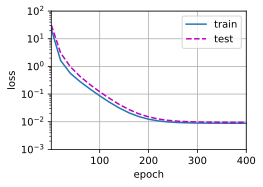

In [17]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

欠拟合

选择前两个维度

weight: [[3.568081  3.7741227]]


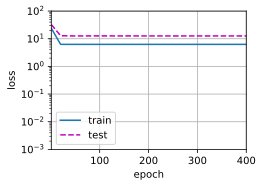

In [19]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

过拟合

选择全部维度，带有噪音

weight: [[ 4.97377     1.2808204  -3.2291124   5.166591   -0.48065394  1.458439
  -0.10931352  0.18465135  0.12877904 -0.06162877  0.06229859 -0.02384419
  -0.15651526 -0.05843591 -0.10220265 -0.21735346 -0.0465573  -0.14114979
   0.19691783  0.06596059]]


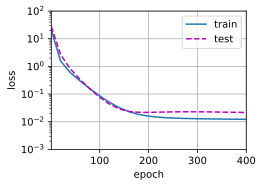

In [20]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])